In [1]:
from completion_network import CompletionNet
from train_ae import make_data_loader
from dataset import NearDetDataset3D,TransformerDataset
import matplotlib.pyplot as plt
import torch
import MinkowskiEngine as ME
import numpy as np

from image_representation.representations.minkowski_nn.vae import MEVAE
from addict import Dict
import os
import shutil

In [2]:
def collation_function(data):
    target_data = [datum['target'] for datum in data]
    input_data = [datum['input'] for datum in data]

    target_coords, target_feats = list(zip(*target_data))
    input_coords, input_feats = list(zip(*input_data))

    # Create batched coordinates for the SparseTensor input
    batched_target_coords = ME.utils.batched_coordinates(target_coords)
    batched_input_coords = ME.utils.batched_coordinates(input_coords)

    # Concatenate all lists
    batched_target_feats = torch.from_numpy(np.concatenate(target_feats, 0)).float()
    batched_input_feats = torch.from_numpy(np.concatenate(input_feats, 0)).float()

    return {
        'input': (batched_input_coords, batched_input_feats),
        'target': (batched_target_coords, batched_target_feats)
    }


dataset = NearDetDataset3D()
dataloader = make_data_loader(
        dataset=dataset,
        batch_size=8,
        shuffle=False,
        collation_function=collation_function,
        num_workers=4
    )

event = next(iter(dataloader))


In [11]:
device = 'cuda'
net = CompletionNet(resolution=128).to(device)
model_weights = torch.load('/data/rradev/sparse-cnn/nd_feature_learning/debug_completion.pth')
net.load_state_dict(model_weights['state_dict'])
net.eval()

event = next(iter(dataloader))
coords_input, feats_input = event['input']
coords_target, feats_target = event['target']
sin = ME.SparseTensor(
            features=feats_input,
            coordinates=coords_input.int(),
            device=device,
        )

cm = sin.coordinate_manager
target_key, _ = cm.insert_and_map(
    coords_target.to(device),
    string_id="target",
)

out_cls, targets, _,  sout = net(sin, target_key)
strue = ME.SparseTensor(
    features=feats_target,
            coordinates=coords_target.int(),
            device=device,
        )


In [12]:
coords, features = sout.decomposed_coordinates_and_features
in_coords, in_features = sin.decomposed_coordinates_and_features
true_coords, true_features = strue.decomposed_coordinates_and_features

(64,)


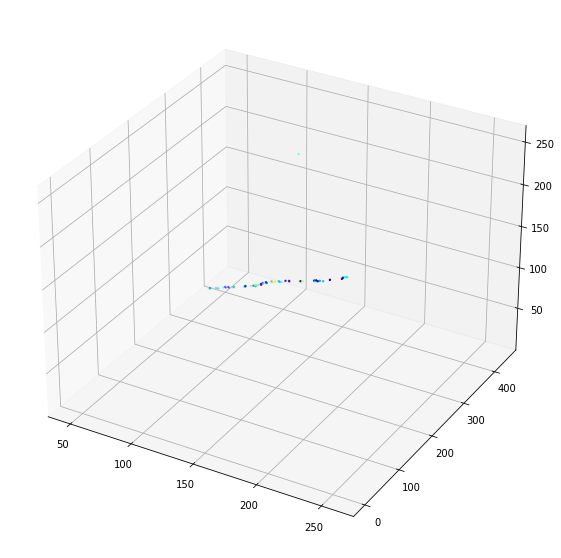

(231,)


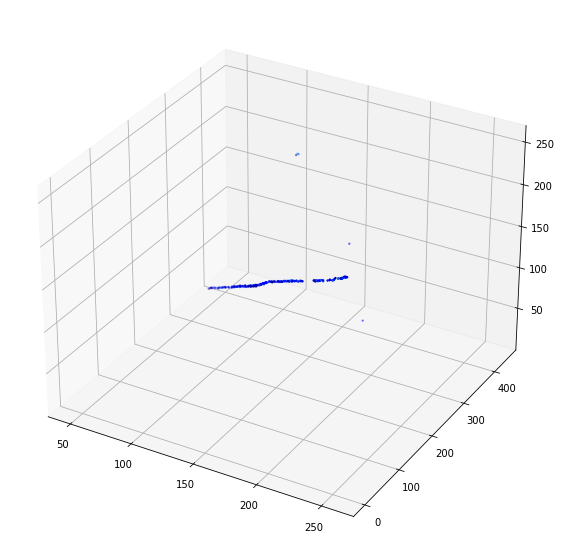

(462,)


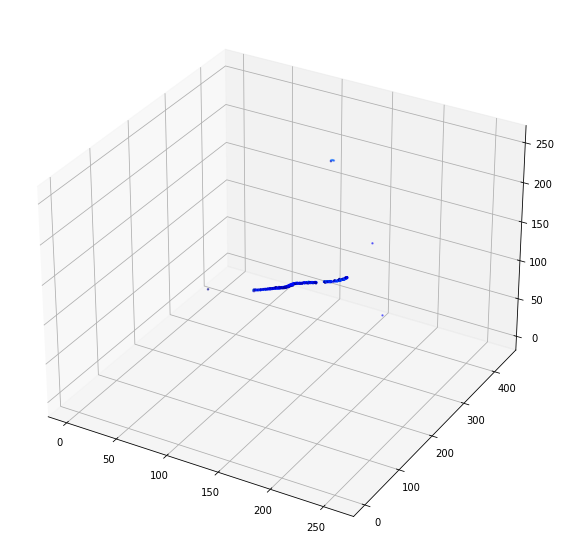

(79,)


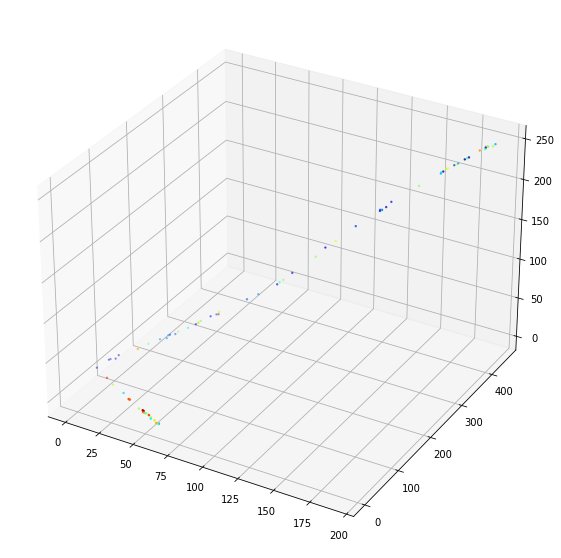

(333,)


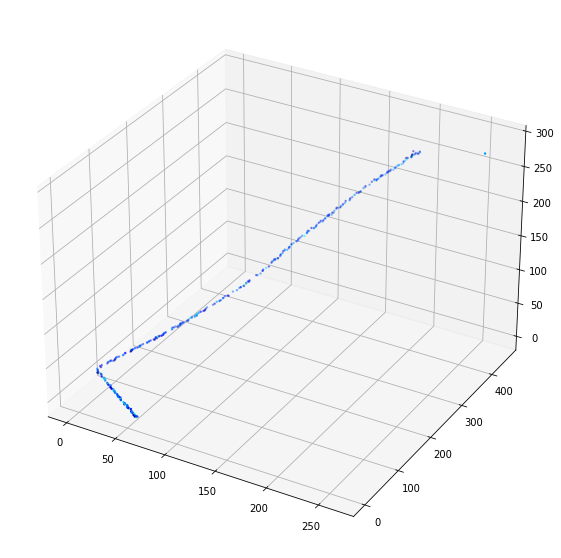

(665,)


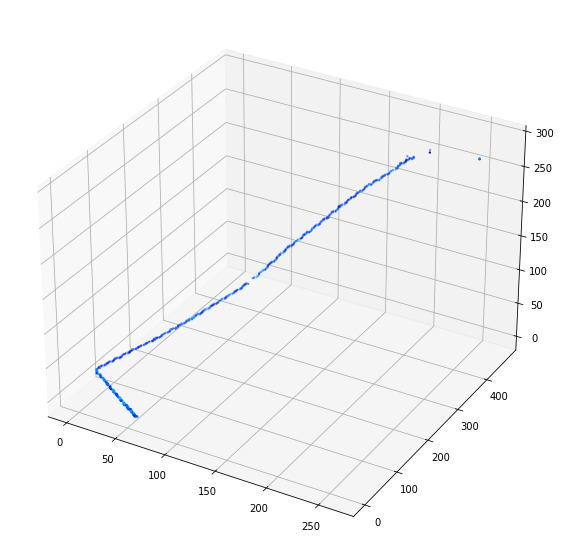

(106,)


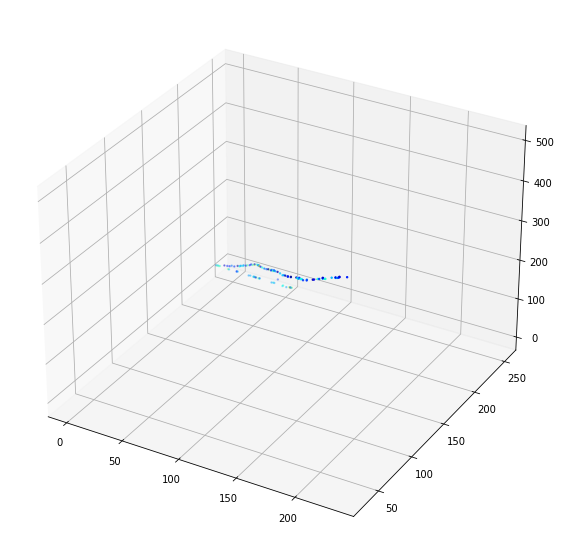

(356,)


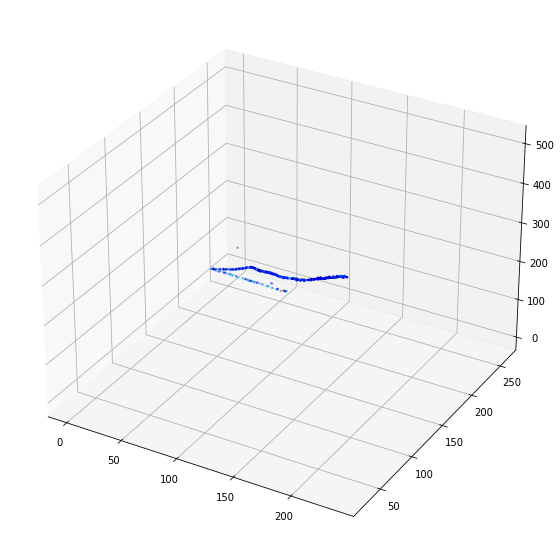

(711,)


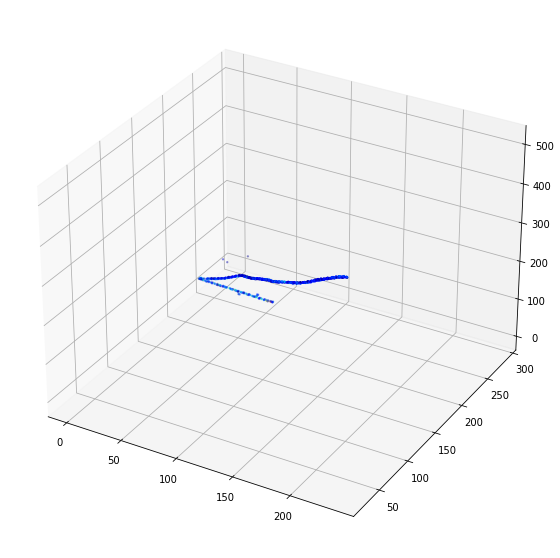

(41,)


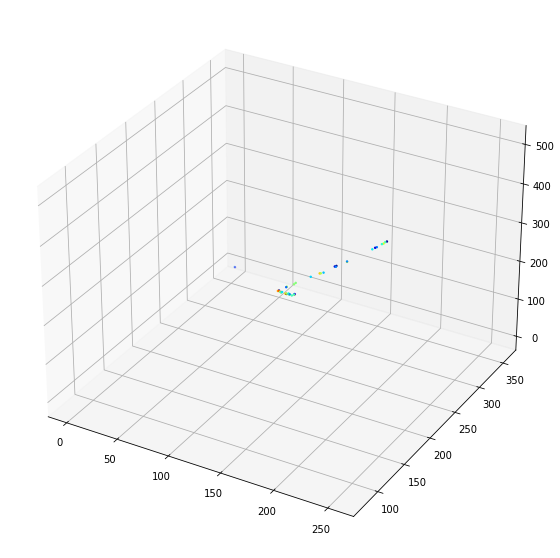

(109,)


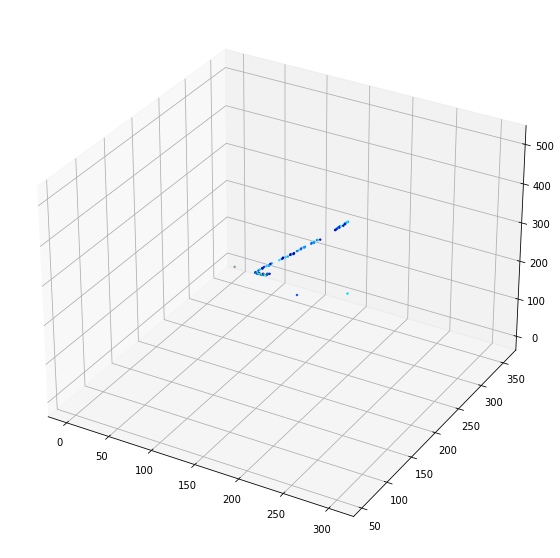

(217,)


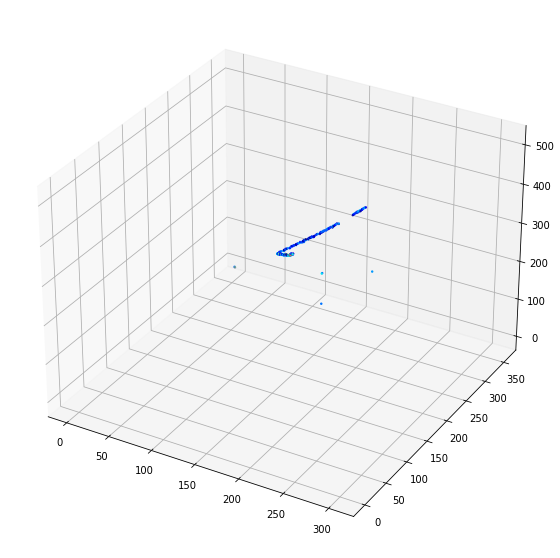

(90,)


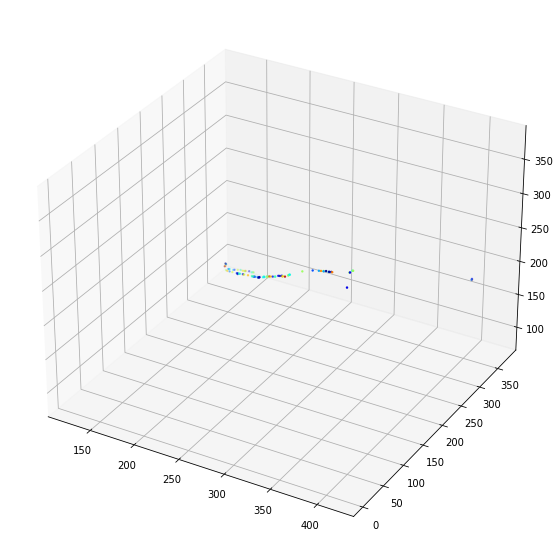

(295,)


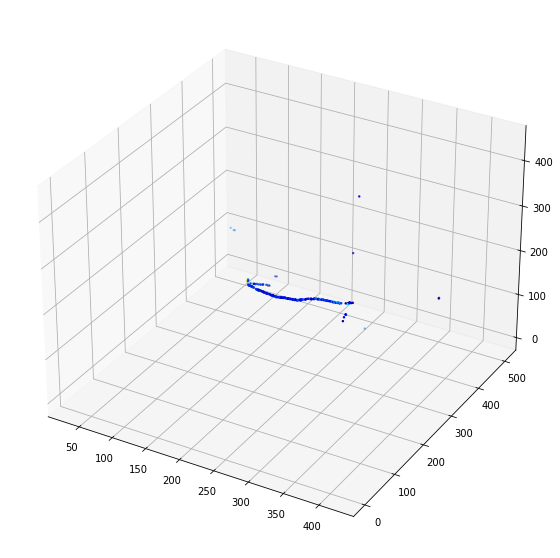

(590,)


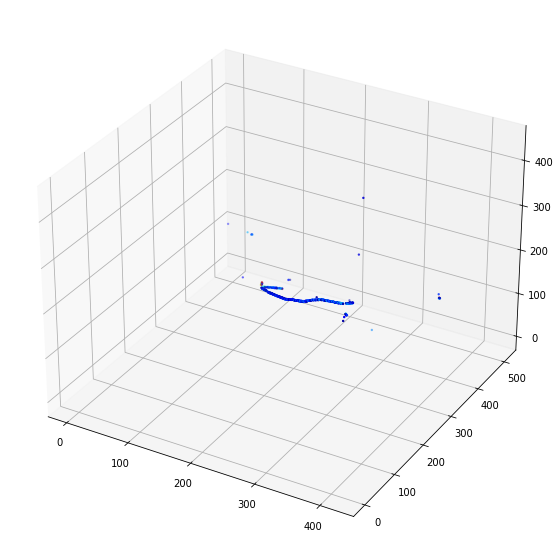

(54,)


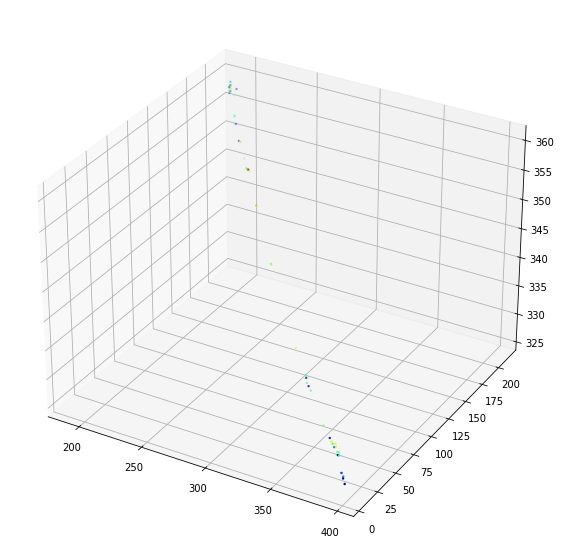

(178,)


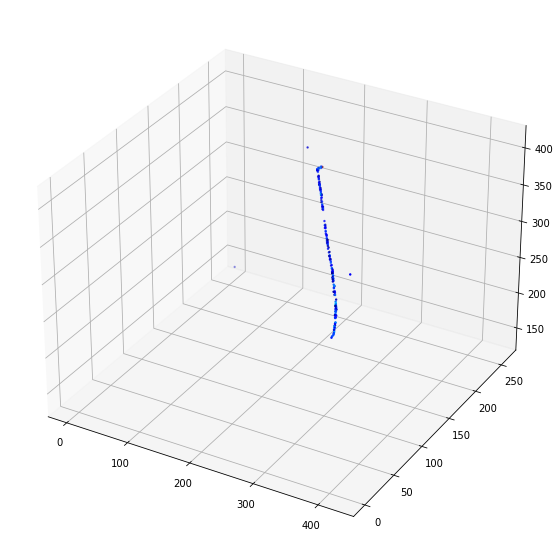

(355,)


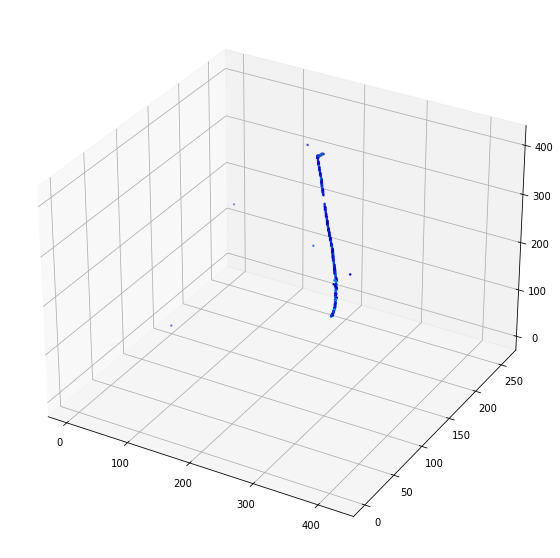

(92,)


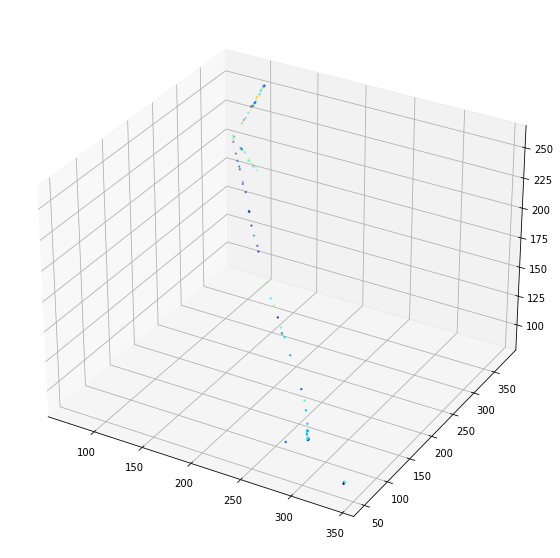

(289,)


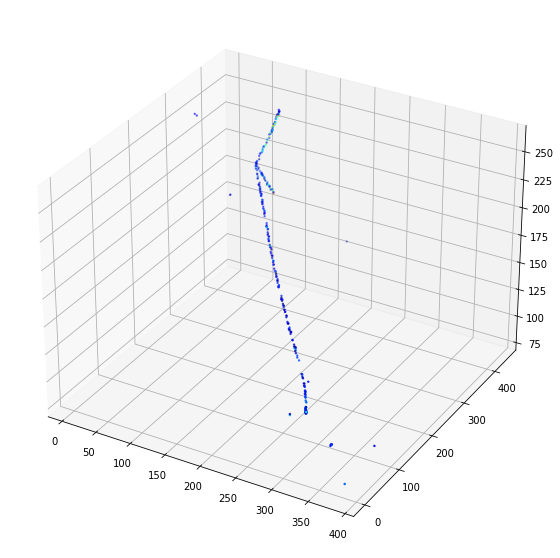

(578,)


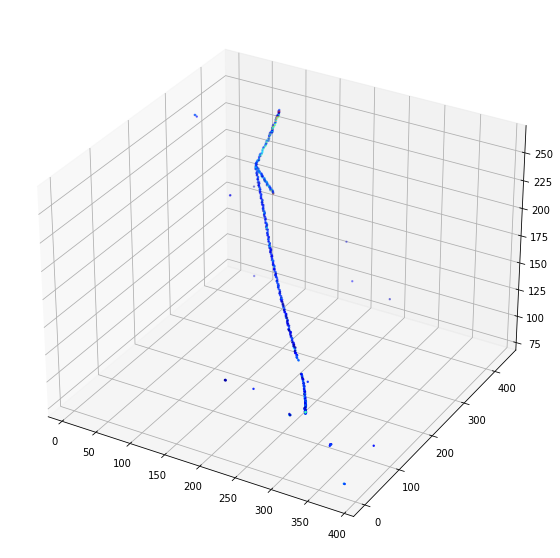

(113,)


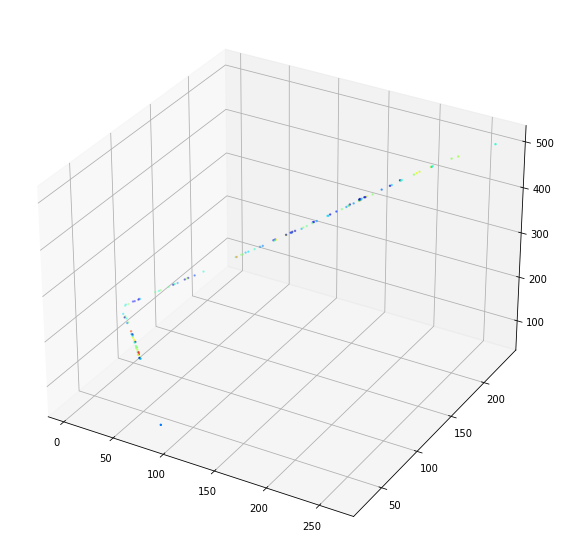

(293,)


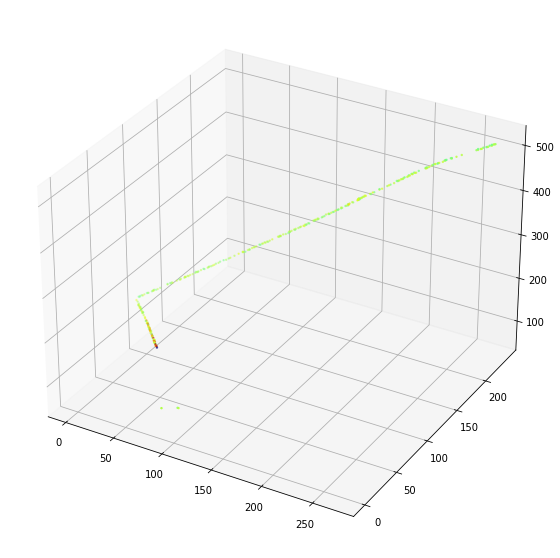

(585,)


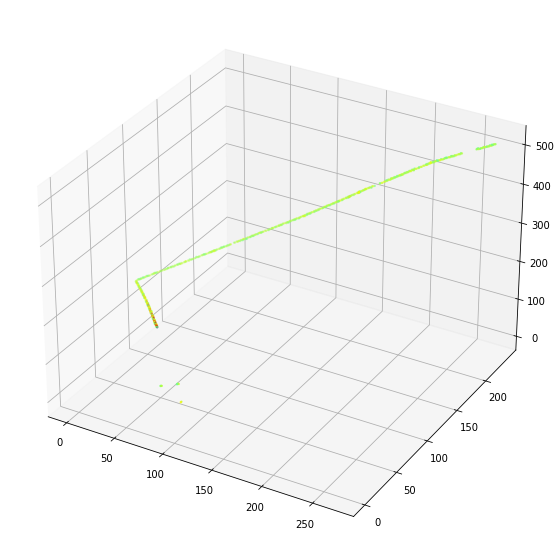

In [13]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

plt.rcParams['figure.figsize'] = (10, 10)

def plot_event(coord, features):
    x, y, z = to_numpy(coord).T
    features = np.array([to_numpy(x) for x in features])
    print(x.shape)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, s=2, c=features, cmap='jet')
    plt.show()
for idx, coord in enumerate(coords):
    plot_event(coord, features[idx])
    plot_event(in_coords[idx], in_features[idx])
    plot_event(true_coords[idx], true_features[idx])

(array([5., 1., 7., 6., 5., 7., 4., 1., 4., 1.]),
 array([0.34314793, 0.35008663, 0.35702533, 0.36396402, 0.37090272,
        0.3778414 , 0.3847801 , 0.3917188 , 0.3986575 , 0.4055962 ,
        0.4125349 ], dtype=float32),
 <BarContainer object of 10 artists>)

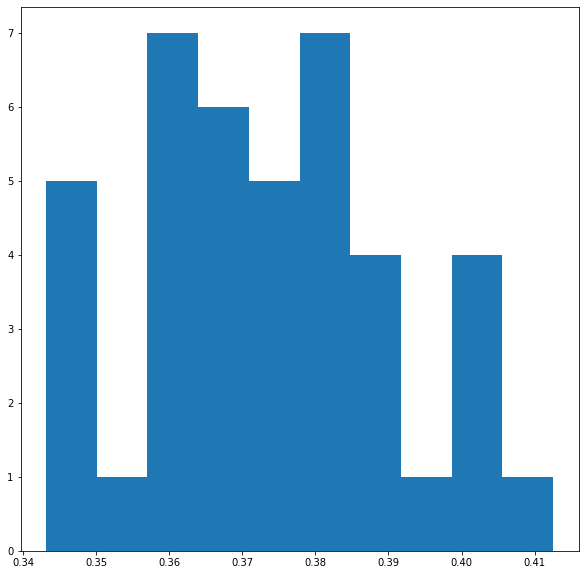

In [18]:
plt.hist(to_numpy(features[3]))


(array([51., 57., 64., 27.,  7.,  5.,  2.,  2.,  1.,  1.]),
 array([0.3137255 , 0.33803922, 0.36235297, 0.3866667 , 0.4109804 ,
        0.43529415, 0.45960787, 0.4839216 , 0.50823534, 0.532549  ,
        0.5568628 ], dtype=float32),
 <BarContainer object of 10 artists>)

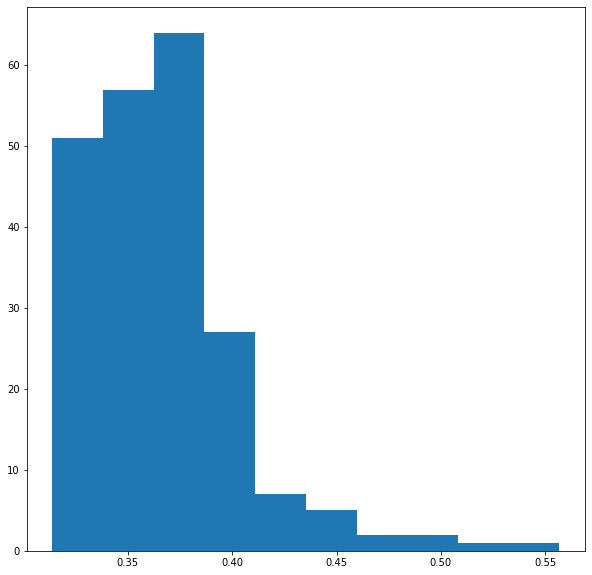

In [19]:
plt.hist(to_numpy(true_features[3]))

In [8]:
np.array([to_numpy(x) for x in features]).shape

/data/rradev/anaconda/envs/minkowski/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(8,)

(array([ 16., 152.,  76.,  43.,  26.,   9.,   4.,   1.,   0.,   1.]),
 array([0.34552947, 0.37086403, 0.39619857, 0.42153314, 0.4468677 ,
        0.47220224, 0.4975368 , 0.5228714 , 0.5482059 , 0.5735405 ,
        0.59887505], dtype=float32),
 <BarContainer object of 10 artists>)

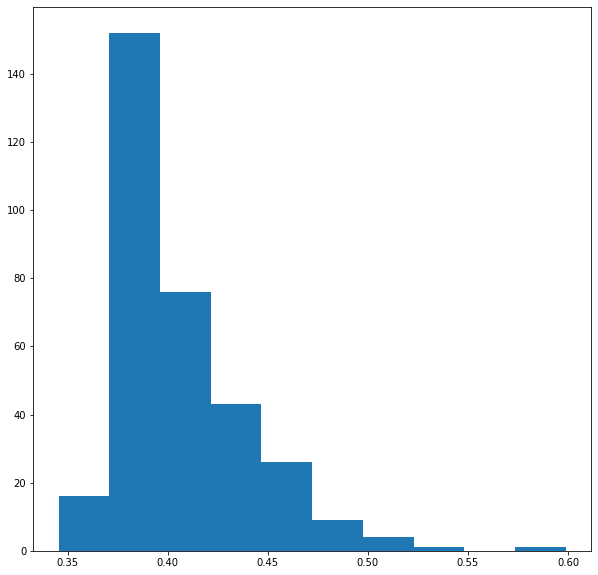

In [9]:
plt.hist(to_numpy(features[1]))